In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

## Background theory

A maximum entropy model is one that 

$$
\begin{equation}
 H = - \sum_i p(x_i) \log \left( p(x_i) \right)
\end{equation}
$$

subject to our equally constraints. This is achieved through the method of Lagrange multipliers, which maximizes a  functional that depends on the constraints as:

$$
\begin{equation}
 \tilde{H} = - \sum_i p(x_i) \log ( p(x_i) ) + \lambda_0 ( ( \sum_i p(x_i) ) - 1 ) + \sum_k \lambda_k ( ( \sum_i p(x_i) f_k(x_i) ) - \sum_i p_\mathrm{emp.}(x_i) f_k(x_i) ).
\end{equation}
$$

The partial derivatives for each $p(x_i)$ is given by:

$$
\begin{equation}
 \frac{\partial \tilde{H}}{\partial p(x_i)} = - \log(p(x_i)) - 1 + \lambda_0 + \sum_k \lambda_k f_k(x_i),
\end{equation}
$$

and by setting these to zero, we learn that each $p(x_i)$ must have the form:

$$
\begin{align}
 0 &= - \log(p(x_i)) - 1 + \lambda_0 + \sum_k \lambda_k f_k(x_i), \\
 \log(p(x_i)) &= -1 + \lambda_0 + \sum_k \lambda_k f_x(x_i), \\
 p(x_i) &= \frac{\exp(\sum_k \lambda_k f_x(x_i))}{\exp(1-\lambda_0)}. \\
\end{align}
$$

The normalization constraint corresponds to setting the partial derivative for $\lambda_0$ to zero:

$$
\begin{align}
 \frac{\partial \tilde{H}}{\partial \lambda_0} &= ( \sum_i p(x_i) ) - 1, \\
 0 &= ( \sum_i p(x_i) ) - 1, \\
 1 &= \sum_i p(x_i), \\
 1 &= \sum_i \frac{\exp(\sum_k \lambda_k f_x(x_i))}{\exp(1-\lambda_0)}, \\
 \exp(1-\lambda_0) &= \sum_i \exp(\sum_k \lambda_k f_x(x_i)).
\end{align}
$$

Thus, it follows that $p(x)$ can be described by:
$$
\begin{align}
 p(x_i) &= \frac{\exp(\sum_k \lambda_k f_x(x_i))}{Z}, \\
 Z &= \sum_i \exp \left( \sum_k \lambda_k f_x(x_i) \right),
\end{align}
$$

and that it belongs to the exponential family. The only parameters left to determine are then $\lambda_1, \ldots, \lambda_K$, which can be found by maximizing the constrained optimization problem $\tilde{H}$ directly or by maximizing a related unconstrained maximum likelihood problem (Berger et al., 1996). Given the empirical distribution $p_\mathrm{emp.}(x_i)$, the mean likelihood $L$ and mean log-likelihood $ll$ functions become:

$$
\begin{align}
 L &= \prod_i p(x_i|\lambda_1,\ldots,\lambda_K)^{p_\mathrm{emp.}(x_i)}, \\
 ll &= \sum_i p_\mathrm{emp.}(x_i) \log(p(x_i|\lambda_1,\ldots,\lambda_K)), \\
    &= \sum_i p_\mathrm{emp.}(x_i) \log(\exp(\sum_k \lambda_k f_x(x_i))) - \sum_i \tilde{p}(x_i) \log(Z).
\end{align}
$$

The maximum of this log-likelihood function can be found using any gradient based method, and the expressions for the first and second partial derivative, respectively, are:

$$
\begin{align}
 \frac{\partial ll}{\partial \lambda_k} &= \sum_i \tilde{p}(x_i) f_k(x_i) - \sum_i \tilde{p}(x_i) \sum_j \frac{ \exp( \sum_k \lambda_k f_k(x_j))}{Z} f_k(x_j), \\
 &= \sum_i \tilde{p}(x_i) f_k(x_i) - \sum_i p(x_i) f_k(x_i), \\
 &= \mathbb{E}_\mathrm{emp.}[f_k(x)] - \mathbb{E}[f_k(x)],\\
 \frac{\partial^2 ll}{\partial \lambda_k \partial \lambda_l} &= - (\mathbb{E}[f_k(x)f_l(x)] - \mathbb{E}[f_k(x)]\mathbb{E}[f_l(x)]).
\end{align}
$$

The expression for the first derivative neatly illustrates that the maximum likelihood approach yields $\lambda$s that constitute a solution to the original optimization problem $\tilde{H}$: the gradient will be zero when all the equality conditions are fulfilled. Similarly, the second derivatives extends upon this and further tells us that we do not just obtain a solution, but the optimal solution: Each second partial derivative occupies one element in the Hessian. Thus, we can conclude that the Hessian is the negative of a covariance matrix, and as covariance matrices are always positive semi-definite, the maximum found is guaranteed to be optimal and unique.

## Practical examples

#### Generate data

[   9.1086  114.0566]
[   9.10860117  114.05662861]


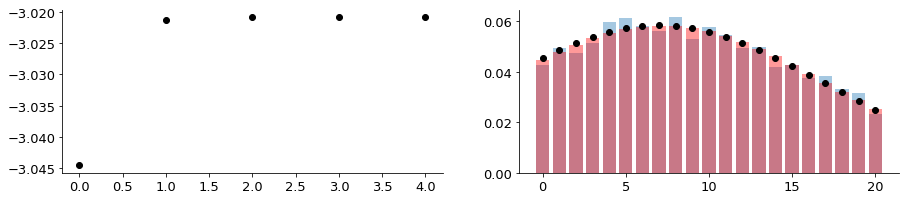

In [67]:
def solveLambdas(sample, outcomes, order=1):

    n_observations, n_dims = sample.shape

    # Generate possible outcome patterns
    pattern_grid = np.meshgrid(*[outcomes for i in range(n_dims)], indexing='ij')
    patterns = np.vstack([grid_tmp.ravel() for grid_tmp in pattern_grid]).T
    
    # Model terms, patterns and higher order terms
    # First order terms first
    model_terms = patterns.copy()
    term_tags = []
    for i in range(n_dims):
        term_tags.append('x%1d' % (i+1))
    # Second order terms
    if order > 1:
        for i in range(n_dims):
            for j in range(i, n_dims):
                tmp_term = patterns[:, i] * patterns[:, j]
                model_terms = np.append(model_terms, tmp_term[:, np.newaxis], axis=1)
                term_tags.append('x%1dx%1d' % (i+1, j+1))
                
    # Empirical pattern probabilitites
    n_patterns = patterns.shape[0]
    pattern_counts = np.zeros(n_patterns)
    for i in range(n_patterns):
        matches = np.where((sample == patterns[i, :]).all(axis=1))[0]
        pattern_counts[i] = matches.size
    p_emp = pattern_counts / pattern_counts.sum()
    constraints_emp = np.dot(p_emp, model_terms)
    
    # Initialize lambdas to zeros (initial guess)
    n_lambdas = model_terms.shape[1]
    lambdas = np.zeros(n_lambdas)
    # Get initial predicted probabilitites
    p_model = np.exp(np.dot(model_terms, lambdas))
    p_model /= p_model.sum()
    
    # Gradient ascent with newton step updates
    converged = False
    n_steps = 0
    ll = []
    ll.append(np.dot(p_emp, np.log(p_model)))
    while not converged:
        
        
        p_model = np.exp(np.dot(model_terms, lambdas))
        p_model /= p_model.sum()
        
        # Get model constraints, the gradient, and the hessian
        constraints_model = np.dot(p_model, model_terms)
        gradient = constraints_emp - constraints_model
        h_term1 = np.dot(model_terms.T, (p_model[:, np.newaxis]*model_terms))
        h_term2 = np.outer(constraints_model, constraints_model)
        hessian = h_term1 - h_term2
        
        # Update the lambdas using one Newton step
        newton_step = np.dot(np.linalg.inv(hessian), gradient)
        lambdas += newton_step
        
        # Get the predicted probabilitites with updated lambdas
        p_model = np.exp(np.dot(model_terms, lambdas))
        p_model /= p_model.sum()
        
        # Update the loglikelihood and check for convergence
        ll.append(np.dot(p_emp, np.log(p_model)))
        if np.abs(ll[-1] - ll[-2]) < 1e-10:
            converged = True
        n_steps += 1
    
    print constraints_emp
    print constraints_model
        
    plt.figure(figsize=(15, 3))
    ax = plt.subplot(1, 2, 1)
    ax.plot(np.arange(0, n_steps+1), ll, 'ko')
    
    return p_emp, p_model
    

n_outcomes = 21
n_observations = 5000
mu = 7.
sigma = 10.

# The true distribution is an exponential distribution
x = np.arange(n_outcomes)
p_exp = 1/mu * np.exp(-x/mu)
p_exp /= p_exp.sum()
p_normal = np.exp(-(x-mu)**2/(2*sigma**2))
p_normal /= p_normal.sum()
p_equal = 1. / n_outcomes * np.ones(n_outcomes)

# Get a sample of n_observations from the true distribution
p_exp_cum = np.cumsum(p_normal)
r_sample = np.random.rand(n_observations)
sample = np.array([np.argmax(r < p_exp_cum) for r in r_sample])
sample = sample[:, np.newaxis]  # Turn into a matrix with one column

#solveLambdas(np.hstack([sample, sample]), x, 2)
p_emp, p_model = solveLambdas(sample, x, 2)

ax = plt.subplot(1, 2, 2)
ax.bar(x, p_emp, alpha=0.4)
ax.bar(x, p_model, color='r', alpha=0.4)
ax.plot(x, p_normal, 'ko')